### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import time

### Reproducability

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
set_seed(31415)

### Constants

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
TRAIN_DIR = 'furniture_dataset/train'
VAL_DIR = 'furniture_dataset/val'
TEST_DIR = 'furniture_dataset/test'

### Function that loads training, validation and test datasets | default image size is 224 x 224

In [5]:
def load_datasets(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    """
    Loads train, validation, and test datasets from directories.
    Yields raw images (pixels 0-255) and labels.
    """
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        label_mode='binary',
        image_size=img_size,
        batch_size=batch_size
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        label_mode='binary',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        label_mode='binary',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    print(f"Loading datasets with image size {img_size}...")
    print(f"Found class names: {train_ds.class_names}")

    # Configure the datasets for high performance on your M3 GPU
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

### Creating a model

In [6]:
def create_model(base_model, preprocess_func, img_shape):
    """Builds a complete model from a base and its preprocess function."""
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the functional model
    inputs = layers.Input(shape=img_shape, name="input_layer")
    
    # Add data augmentation as a layer
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.2)(x)
    
    # Add the model-specific preprocessing as a layer
    x = preprocess_func(x)
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x) # Binary classification
    
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.legacy.Adam(),
        metrics=["binary_accuracy"]
    )
    return model

### Models

In [7]:
# --- Getter function for MobileNetV2 ---
def get_mobilenet_v2_model(img_shape=(224, 224, 3)):
    from keras.applications import MobileNetV2
    from keras.applications.mobilenet_v2 import preprocess_input
    
    base = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
    return create_model(base, preprocess_input, img_shape)

def get_mobilenet_v3_small_model(img_shape=(224, 224, 3)):
    """Returns a compiled MobileNetV3-Small model."""
    # 1. Import the V3 model and its preprocessing function
    from keras.applications import MobileNetV3Small
    from keras.applications.mobilenet_v3 import preprocess_input
    
    # 2. Get the base model
    base = MobileNetV3Small(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    
    return create_model(base, preprocess_input, img_shape)

def get_mobilenet_v3_large_model(img_shape=(224, 224, 3)):
    """Returns a compiled MobileNetV3-Large model."""
    
    # 1. Import the specific V3-Large model
    from keras.applications import MobileNetV3Large
    from keras.applications.mobilenet_v3 import preprocess_input
    
    # 2. Instantiate the base model
    base = MobileNetV3Large(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    
    return create_model(base, preprocess_input, img_shape)


def get_resnet50_model(img_shape=(224, 224, 3)):
    from keras.applications import ResNet50
    from keras.applications.resnet import preprocess_input
    
    base = ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')
    return create_model(base, preprocess_input, img_shape)

def get_resnet50_v2_model(img_shape=(224, 224, 3)):
    """Returns a compiled ResNet50V2 model."""
    
    # 1. Import the V2 model and its specific preprocessing function
    from keras.applications import ResNet50V2
    from keras.applications.resnet_v2 import preprocess_input
    
    # 2. Instantiate the base model
    base = ResNet50V2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # 3. Use our existing model factory to build the full model
    return create_model(base, preprocess_input, img_shape)

def get_efficientnet_b0_model(img_shape=(224, 224, 3)):
    from keras.applications import EfficientNetB0
    from keras.applications.efficientnet import preprocess_input 
    
    base = EfficientNetB0(input_shape=img_shape, include_top=False, weights='imagenet')
    return create_model(base, preprocess_input, img_shape)

def get_densenet121_model(img_shape=(224, 224, 3)):
    from keras.applications import DenseNet121
    from keras.applications.densenet import preprocess_input
    
    base = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet')
    return create_model(base, preprocess_input, img_shape)

def get_xception_model(img_shape=(299, 299, 3)):
    from keras.applications import Xception
    from keras.applications.xception import preprocess_input
    
    base = Xception(input_shape=img_shape, include_top=False, weights='imagenet')
    return create_model(base, preprocess_input, img_shape)

### Evaluation

In [8]:
def plot_training_history(history, save_path):
    """
    Takes a Keras training history object and plots/saves the loss and accuracy curves.
    """
    print("\n--- Generating Training Plots ---")

    # Get the data from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Check for 'binary_accuracy' or 'accuracy'
    if 'binary_accuracy' in history.history:
        train_acc_key = 'binary_accuracy'
        val_acc_key = 'val_binary_accuracy'
    else:
        train_acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
        
    train_acc = history.history[train_acc_key]
    val_acc = history.history[val_acc_key]

    # Get the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # --- Create Plot 1: Training & Validation Loss ---
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # --- Create Plot 2: Training & Validation Accuracy ---
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout() # Adjusts plots to prevent overlap

    # Save the combined plot as an image
    plt.savefig(save_path)
    print(f"Training plots saved to {save_path}")
    plt.show()


def print_classification_report(y_true, y_pred_classes, class_names, model_save_path):
    """
    Prints a full classification report, including model file size.
    """
    print("\n--- Classification Report ---")
    
    # 1. Accuracy, Precision, Recall, F1-score
    # This function builds a text report showing all the main metrics.
    report = classification_report(y_true, y_pred_classes, target_names=class_names)
    print(report)

    # 2. Model Size
    if os.path.exists(model_save_path):
        model_size_bytes = os.path.getsize(model_save_path)
        model_size_mb = model_size_bytes / (1024 * 1024)
        print(f"--- Model Size ---")
        print(f"Model saved at: {model_save_path}")
        print(f"File Size: {model_size_mb:.2f} MB")
    else:
        print(f"Could not find model file at: {model_save_path}")

In [9]:
def inference_latency(test_ds, model, modelName):
    # taking the first batch from test_ds
    first_batch  = test_ds.take(1)
    
    for images, labels in first_batch:
        # 'images' is a tensor of shape (32, 224, 224, 3)
        # 'labels' is a tensor of shape (32,)
        
        # Get the very first image from the batch tensor
        single_real_image = images[0] # Shape is now (224, 224, 3)
        
        # The model expects a batch, so we add a dimension at the front
        single_real_image_batch = tf.expand_dims(single_real_image, axis=0) # Shape is now (1, 224, 224, 3)
        
        print(f"Successfully extracted one image with shape: {single_real_image_batch.shape}")
        break # We only need one, so we exit the loop
    
    print(f"\n--- Benchmarking LATENCY with a real image for {modelName}---")
    
    # Warm-up run with the real image
    print("Warming up model...")
    model.predict(single_real_image_batch, verbose=0)
    print("Warm-up complete.")

    # Timed run
    N_ITERATIONS = 100
    print(f"Running {N_ITERATIONS} predictions for latency test...")
    start_time = time.perf_counter()
    for _ in range(N_ITERATIONS):
        model.predict(single_real_image_batch, verbose=0)
    end_time = time.perf_counter()

    # Calculate and print latency
    total_time = end_time - start_time
    avg_latency_ms = (total_time / N_ITERATIONS) * 1000
    print(f"Average Latency (on a real image): {avg_latency_ms:.2f} ms")
    

In [10]:
train_ds, val_ds, test_ds = load_datasets(
    TRAIN_DIR, VAL_DIR, TEST_DIR, img_size=IMG_SIZE, batch_size=BATCH_SIZE
)

Found 2725 files belonging to 2 classes.
Found 583 files belonging to 2 classes.
Found 587 files belonging to 2 classes.
Loading datasets with image size (224, 224)...
Found class names: ['environment', 'studio']


### MobileNetV2

In [37]:
MODEL_NAME = "mobilenet_v2_model.keras"
model = get_mobilenet_v2_model(img_shape=IMG_SIZE + (3,))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                           

In [25]:
early_stopping_callback = EarlyStopping(
    min_delta = 0.001,
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce Learning Rate on Plateau: Reduce LR when val_loss plateaus for 2 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 5 (1/5)
    patience=2,
    min_lr=0.00001, # Don't let the learning rate get too small
    verbose=1
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 9s - loss: 0.1562 - binary_accuracy: 0.9541 - val_loss: 0.0923 - val_binary_accuracy: 0.9777 - lr: 0.0010 - 9s/epoch - 101ms/step
Epoch 2/100
86/86 - 7s - loss: 0.0411 - binary_accuracy: 0.9934 - val_loss: 0.0730 - val_binary_accuracy: 0.9794 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 3/100
86/86 - 7s - loss: 0.0253 - binary_accuracy: 0.9967 - val_loss: 0.0544 - val_binary_accuracy: 0.9880 - lr: 0.0010 - 7s/epoch - 81ms/step
Epoch 4/100
86/86 - 7s - loss: 0.0167 - binary_accuracy: 0.9967 - val_loss: 0.0415 - val_binary_accuracy: 0.9931 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 5/100
86/86 - 7s - loss: 0.0149 - binary_accuracy: 0.9974 - val_loss: 0.0319 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 7s/epoch - 76ms/step
Epoch 6/100
86/86 - 6s - loss: 0.0125 - binary_accuracy: 0.9982 - val_loss: 0.0297 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 6s/epoch - 75ms/step
Epoch 7/100
86/86 - 7s - loss: 0.0110 - binary_accuracy: 0.9982 - val_loss: 0.0267 - val_binary_accuracy:

In [27]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 1s 63ms/step - loss: 0.0263 - binary_accuracy: 0.9949
Final Test Accuracy: 99.49%


In [28]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

Model successfully saved to mobilenet_v2_model.keras


/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



--- Generating Predictions for Reports ---
19/19 [==============================] - 1s 57ms/step

--- Generating Training Plots ---
Training plots saved to mobilenet_v2_history.png


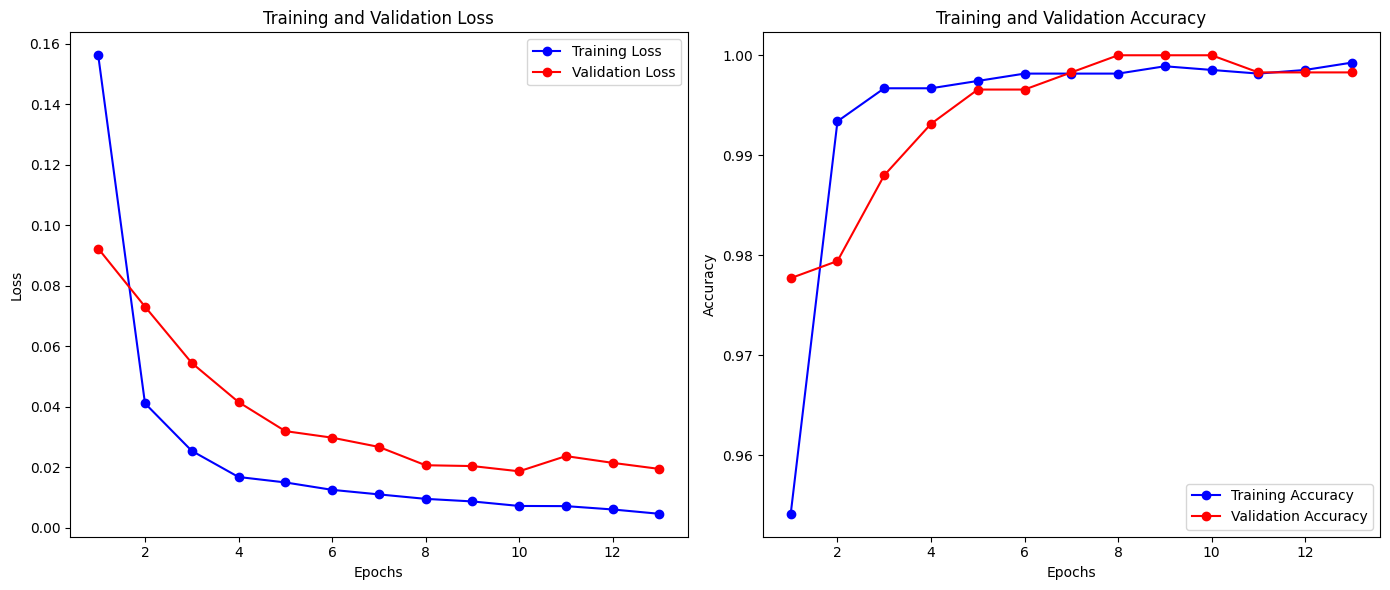


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      1.00      0.99       295
      studio       1.00      0.99      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

--- Model Size ---
Model saved at: mobilenet_v2_model.keras
File Size: 8.95 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to mobilenet_v2_model.png


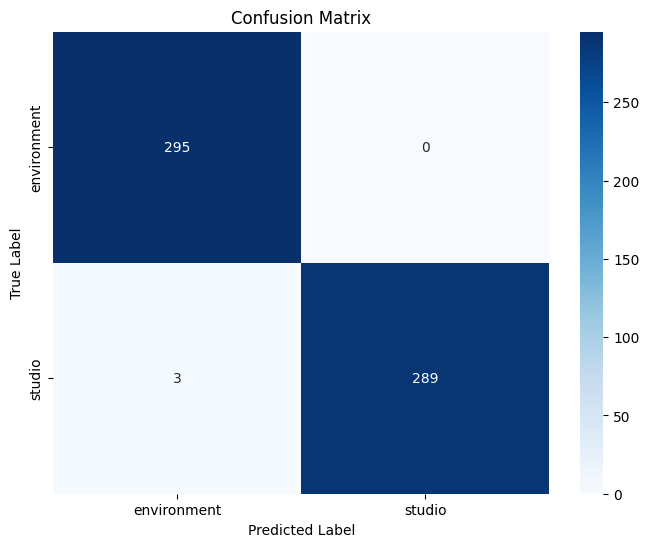

In [29]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path="mobilenet_v2_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [36]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for mobilenet_v2_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 30.53 ms


### MobileNetV3Large

In [38]:
MODEL_NAME = "mobilenet_v3_large_model.keras"
model = get_mobilenet_v3_large_model(img_shape=IMG_SIZE + (3,))
model.summary()

12683000/12683000 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                  

In [39]:
early_stopping_callback = EarlyStopping(
    min_delta = 0.001,
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce Learning Rate on Plateau: Reduce LR when val_loss plateaus for 2 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 5 (1/5)
    patience=2,
    min_lr=0.00001, # Don't let the learning rate get too small
    verbose=1
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 11s - loss: 0.1482 - binary_accuracy: 0.9490 - val_loss: 0.0517 - val_binary_accuracy: 0.9931 - lr: 0.0010 - 11s/epoch - 123ms/step
Epoch 2/100
86/86 - 7s - loss: 0.0320 - binary_accuracy: 0.9923 - val_loss: 0.0289 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 7s/epoch - 80ms/step
Epoch 3/100
86/86 - 7s - loss: 0.0189 - binary_accuracy: 0.9978 - val_loss: 0.0201 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 4/100
86/86 - 7s - loss: 0.0135 - binary_accuracy: 0.9982 - val_loss: 0.0155 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 5/100
86/86 - 7s - loss: 0.0111 - binary_accuracy: 0.9974 - val_loss: 0.0122 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 7s/epoch - 78ms/step
Epoch 6/100
86/86 - 7s - loss: 0.0098 - binary_accuracy: 0.9989 - val_loss: 0.0106 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 7s/epoch - 79ms/step
Epoch 7/100
86/86 - 7s - loss: 0.0075 - binary_accuracy: 0.9985 - val_loss: 0.0091 - val_binary_accurac

In [41]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 2s 82ms/step - loss: 0.0086 - binary_accuracy: 0.9983
Final Test Accuracy: 99.83%


In [42]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

Model successfully saved to mobilenet_v3_large_model.keras


/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



--- Generating Predictions for Reports ---
19/19 [==============================] - 2s 68ms/step

--- Generating Training Plots ---
Training plots saved to mobilenet_v2_history.png


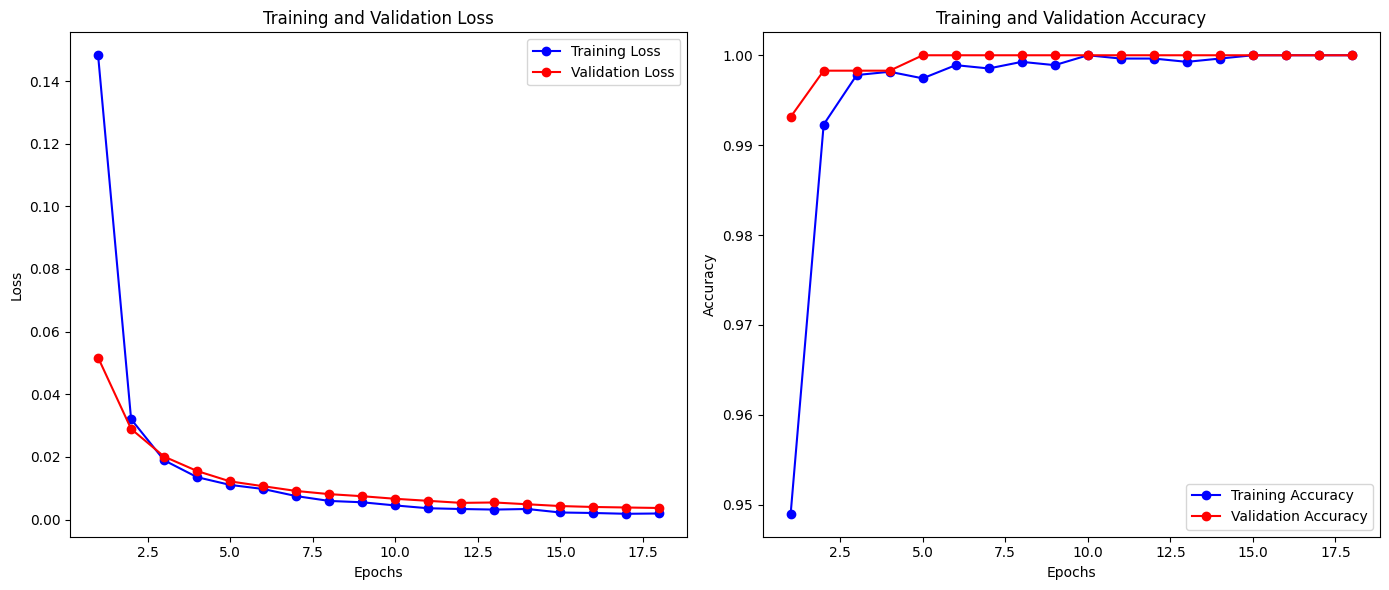


--- Classification Report ---
              precision    recall  f1-score   support

 environment       1.00      1.00      1.00       295
      studio       1.00      1.00      1.00       292

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587

--- Model Size ---
Model saved at: mobilenet_v3_large_model.keras
File Size: 11.81 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to mobilenet_v3_large_model.png


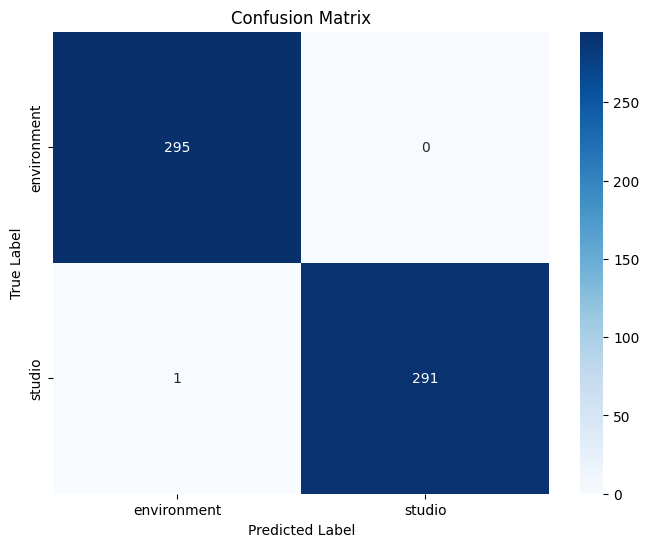

In [43]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path="mobilenet_v2_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [54]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for mobilenet_v3_large_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 34.94 ms


### MobileNetV3Small

In [11]:
MODEL_NAME = "mobilenet_v3_small_model.keras"
model = get_mobilenet_v3_small_model(img_shape=IMG_SIZE + (3,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [12]:
early_stopping_callback = EarlyStopping(
    min_delta = 0.001,
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce Learning Rate on Plateau: Reduce LR when val_loss plateaus for 2 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 5 (1/5)
    patience=2,
    min_lr=0.00001, # Don't let the learning rate get too small
    verbose=1
)

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 15s - loss: 0.2031 - binary_accuracy: 0.9321 - val_loss: 0.0708 - val_binary_accuracy: 0.9897 - lr: 0.0010 - 15s/epoch - 169ms/step
Epoch 2/100
86/86 - 4s - loss: 0.0449 - binary_accuracy: 0.9923 - val_loss: 0.0412 - val_binary_accuracy: 0.9949 - lr: 0.0010 - 4s/epoch - 51ms/step
Epoch 3/100
86/86 - 4s - loss: 0.0272 - binary_accuracy: 0.9956 - val_loss: 0.0267 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 4s/epoch - 46ms/step
Epoch 4/100
86/86 - 4s - loss: 0.0192 - binary_accuracy: 0.9982 - val_loss: 0.0209 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 4s/epoch - 42ms/step
Epoch 5/100
86/86 - 4s - loss: 0.0161 - binary_accuracy: 0.9982 - val_loss: 0.0172 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 4s/epoch - 42ms/step
Epoch 6/100
86/86 - 4s - loss: 0.0134 - binary_accuracy: 0.9974 - val_loss: 0.0140 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 4s/epoch - 44ms/step
Epoch 7/100
86/86 - 4s - loss: 0.0106 - binary_accuracy: 0.9985 - val_loss: 0.0123 - val_binary_accurac

In [14]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 2s 87ms/step - loss: 0.0081 - binary_accuracy: 0.9983
Final Test Accuracy: 99.83%


In [19]:
model.save("mobilenet_v3_small_model", save_format = "tf")
print(f"Model successfully saved to {MODEL_NAME}")

INFO:tensorflow:Assets written to: mobilenet_v3_small_model/assets


INFO:tensorflow:Assets written to: mobilenet_v3_small_model/assets


Model successfully saved to mobilenet_v3_small_model.keras



--- Generating Predictions for Reports ---
19/19 [==============================] - 1s 26ms/step

--- Generating Training Plots ---
Training plots saved to mobilenet_v3_small_model-TrainingHistory.png


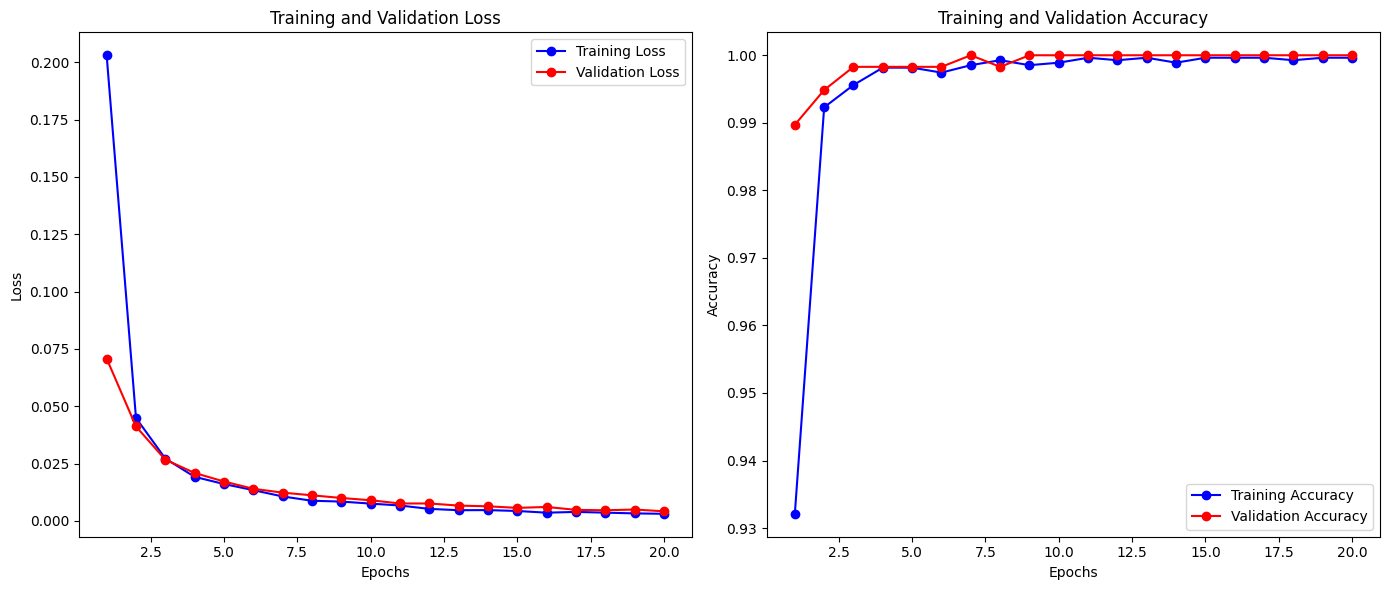


--- Classification Report ---
              precision    recall  f1-score   support

 environment       1.00      1.00      1.00       295
      studio       1.00      1.00      1.00       292

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587

--- Model Size ---
Model saved at: mobilenet_v3_small_model.keras
File Size: 4.22 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to mobilenet_v3_small_model.png


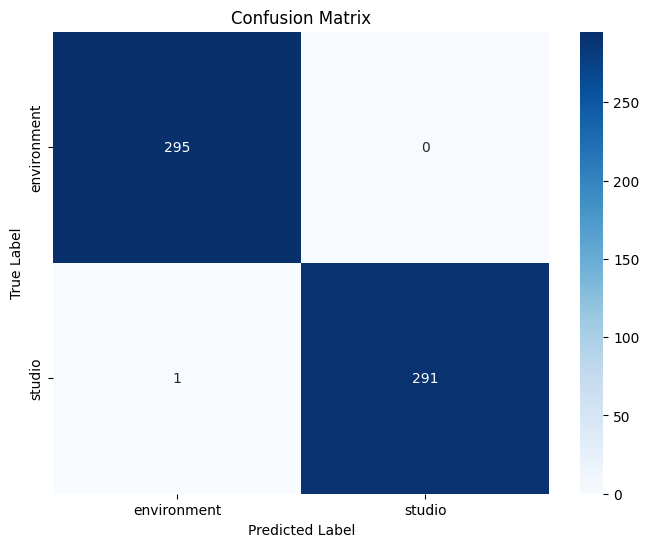

In [18]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}-TrainingHistory.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}-ConfusionMatrix.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [67]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for mobilenet_v3_small_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 31.94 ms


### ResNet50

In [68]:
MODEL_NAME = "resnet50_furniture_model.keras"
model = get_resnet50_model(img_shape=IMG_SIZE + (3,))
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                           

In [70]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 15s - loss: 0.0039 - binary_accuracy: 0.9996 - val_loss: 0.0071 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 15s/epoch - 172ms/step
Epoch 2/100
86/86 - 15s - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 0.0054 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 15s/epoch - 170ms/step
Epoch 3/100
86/86 - 14s - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 0.0044 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 14s/epoch - 169ms/step
Epoch 4/100
86/86 - 15s - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 0.0037 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 15s/epoch - 170ms/step
Epoch 5/100
86/86 - 14s - loss: 0.0012 - binary_accuracy: 1.0000 - val_loss: 0.0034 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 14s/epoch - 168ms/step
Epoch 6/100
86/86 - 14s - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 0.0029 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 14s/epoch - 167ms/step
Epoch 7/100
86/86 - 14s - loss: 9.5083e-04 - binary_accuracy: 1.0000 - val_loss: 0.0031 

In [71]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 3s 138ms/step - loss: 0.0072 - binary_accuracy: 0.9966
Final Test Accuracy: 99.66%


In [72]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully saved to resnet50_furniture_model.keras



--- Generating Predictions for Reports ---
19/19 [==============================] - 3s 134ms/step

--- Generating Training Plots ---
Training plots saved to resnet50_furniture_model_history.png


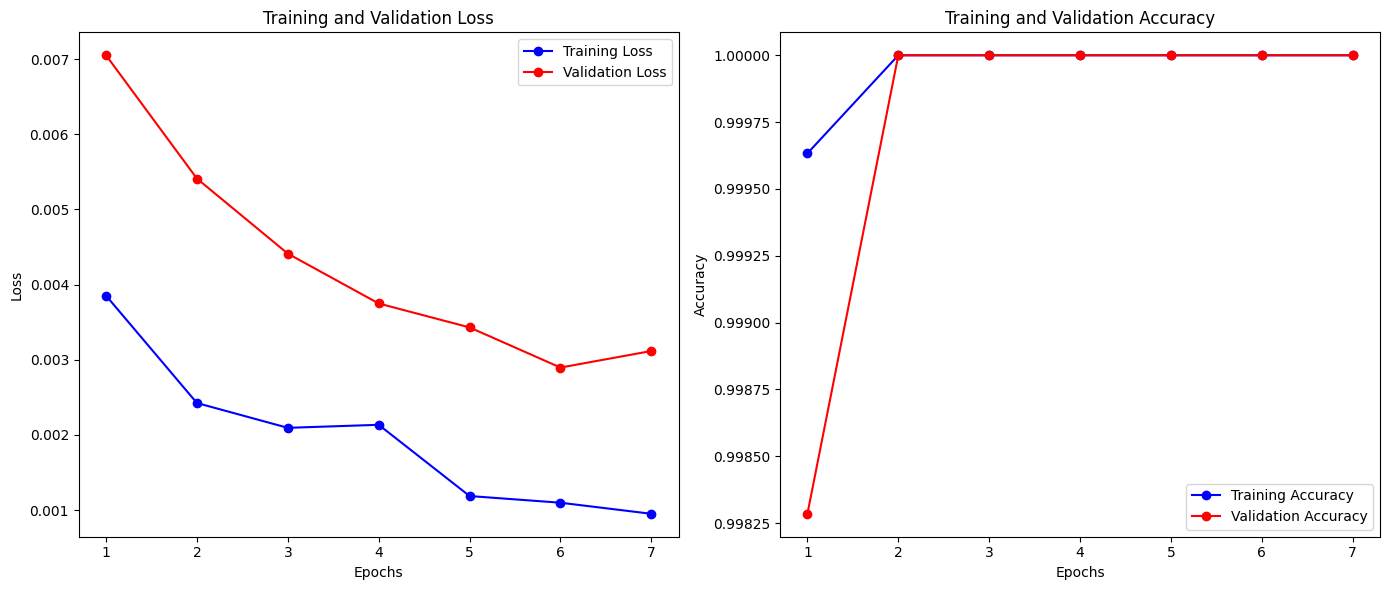


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      1.00      1.00       295
      studio       1.00      0.99      1.00       292

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587

--- Model Size ---
Model saved at: resnet50_furniture_model.keras
File Size: 90.35 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to resnet50_furniture_model.png


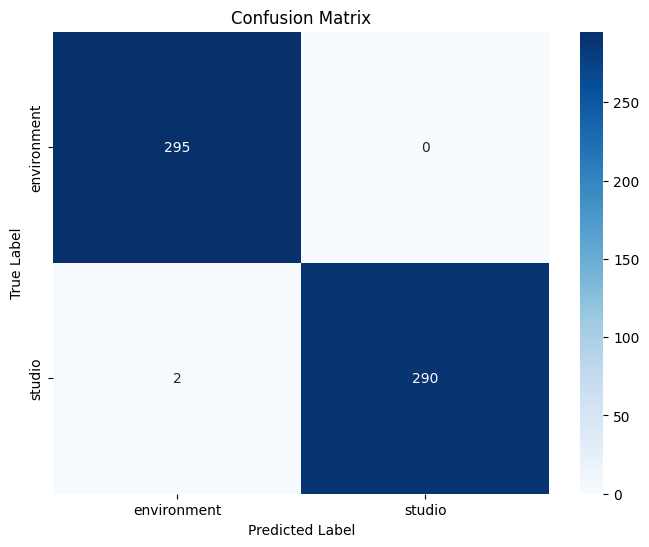

In [73]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [77]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for resnet50_furniture_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 39.24 ms


### ResNet50v2

In [79]:
MODEL_NAME = "resnet50_v2_furniture_model.keras"
model = get_resnet50_v2_model(img_shape=IMG_SIZE + (3,))
model.summary()

94668760/94668760 [==============================] - 10s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_6 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                     

In [80]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 16s - loss: 0.1345 - binary_accuracy: 0.9508 - val_loss: 0.0502 - val_binary_accuracy: 0.9931 - lr: 0.0010 - 16s/epoch - 190ms/step
Epoch 2/100
86/86 - 13s - loss: 0.0294 - binary_accuracy: 0.9927 - val_loss: 0.0275 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 13s/epoch - 151ms/step
Epoch 3/100
86/86 - 13s - loss: 0.0186 - binary_accuracy: 0.9963 - val_loss: 0.0183 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 13s/epoch - 152ms/step
Epoch 4/100
86/86 - 13s - loss: 0.0106 - binary_accuracy: 0.9989 - val_loss: 0.0136 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 13s/epoch - 151ms/step
Epoch 5/100
86/86 - 13s - loss: 0.0087 - binary_accuracy: 0.9978 - val_loss: 0.0115 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 13s/epoch - 151ms/step
Epoch 6/100
86/86 - 13s - loss: 0.0057 - binary_accuracy: 0.9993 - val_loss: 0.0099 - val_binary_accuracy: 1.0000 - lr: 0.0010 - 13s/epoch - 152ms/step
Epoch 7/100
86/86 - 13s - loss: 0.0074 - binary_accuracy: 0.9993 - val_loss: 0.0087 - va

In [81]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 2s 122ms/step - loss: 0.0123 - binary_accuracy: 0.9949
Final Test Accuracy: 99.49%


In [82]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully saved to resnet50_v2_furniture_model.keras



--- Generating Predictions for Reports ---
19/19 [==============================] - 3s 121ms/step

--- Generating Training Plots ---
Training plots saved to resnet50_v2_furniture_model_history.png


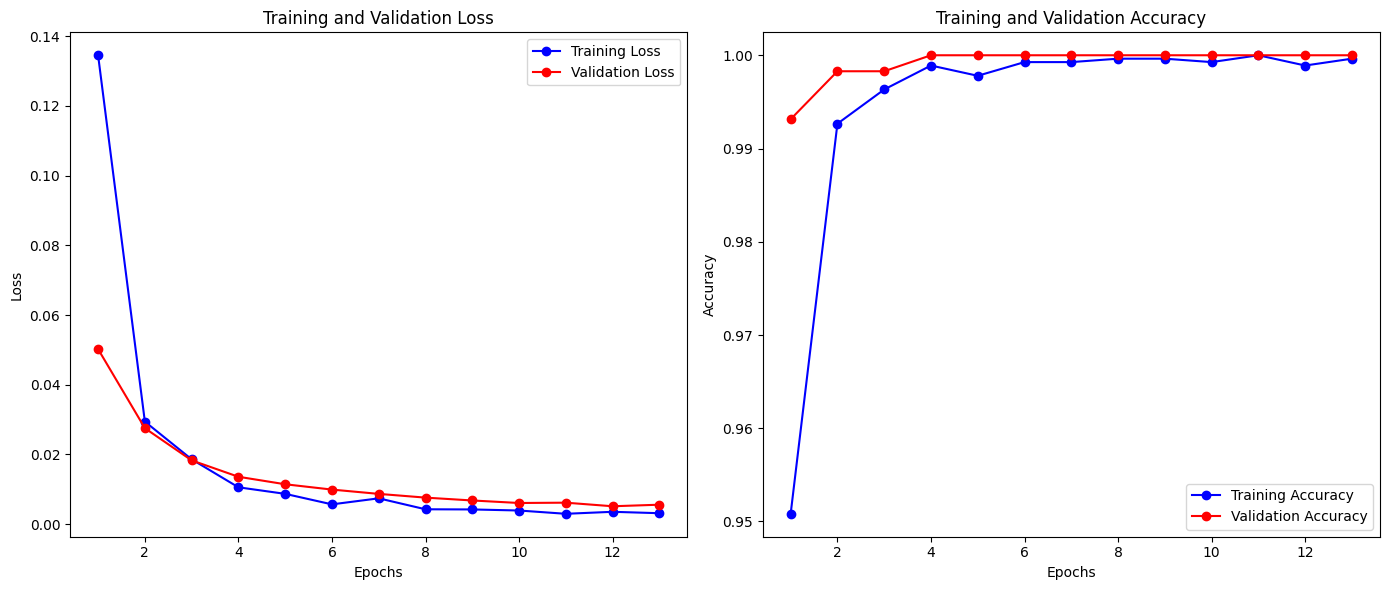


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      1.00      0.99       295
      studio       1.00      0.99      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

--- Model Size ---
Model saved at: resnet50_v2_furniture_model.keras
File Size: 90.24 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to resnet50_v2_furniture_model.png


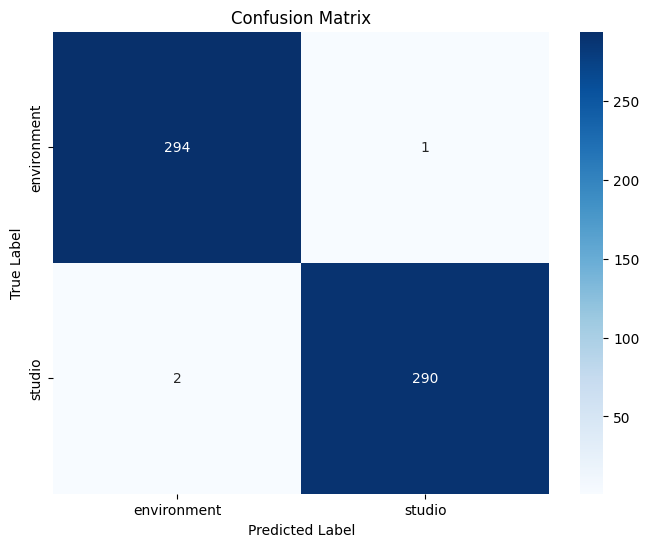

In [83]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [86]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for resnet50_v2_furniture_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 36.49 ms


### EfficientNetB0

In [87]:
MODEL_NAME = "efficientnetb0_furniture_model.keras"
model = get_efficientnet_b0_model(img_shape=IMG_SIZE + (3,))
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_7 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                           

In [88]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 16s - loss: 0.1888 - binary_accuracy: 0.9464 - val_loss: 0.0784 - val_binary_accuracy: 0.9897 - lr: 0.0010 - 16s/epoch - 185ms/step
Epoch 2/100
86/86 - 10s - loss: 0.0417 - binary_accuracy: 0.9945 - val_loss: 0.0471 - val_binary_accuracy: 0.9949 - lr: 0.0010 - 10s/epoch - 122ms/step
Epoch 3/100
86/86 - 10s - loss: 0.0254 - binary_accuracy: 0.9960 - val_loss: 0.0347 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 10s/epoch - 120ms/step
Epoch 4/100
86/86 - 10s - loss: 0.0162 - binary_accuracy: 0.9982 - val_loss: 0.0280 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 10s/epoch - 119ms/step
Epoch 5/100
86/86 - 10s - loss: 0.0134 - binary_accuracy: 0.9985 - val_loss: 0.0235 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 10s/epoch - 118ms/step
Epoch 6/100
86/86 - 10s - loss: 0.0103 - binary_accuracy: 0.9996 - val_loss: 0.0196 - val_binary_accuracy: 0.9966 - lr: 0.0010 - 10s/epoch - 120ms/step
Epoch 7/100
86/86 - 10s - loss: 0.0092 - binary_accuracy: 0.9993 - val_loss: 0.0179 - va

In [89]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 2s 120ms/step - loss: 0.0195 - binary_accuracy: 0.9966
Final Test Accuracy: 99.66%


In [90]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

Model successfully saved to efficientnetb0_furniture_model.keras


/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



--- Generating Predictions for Reports ---
19/19 [==============================] - 2s 89ms/step

--- Generating Training Plots ---
Training plots saved to efficientnetb0_furniture_model_history.png


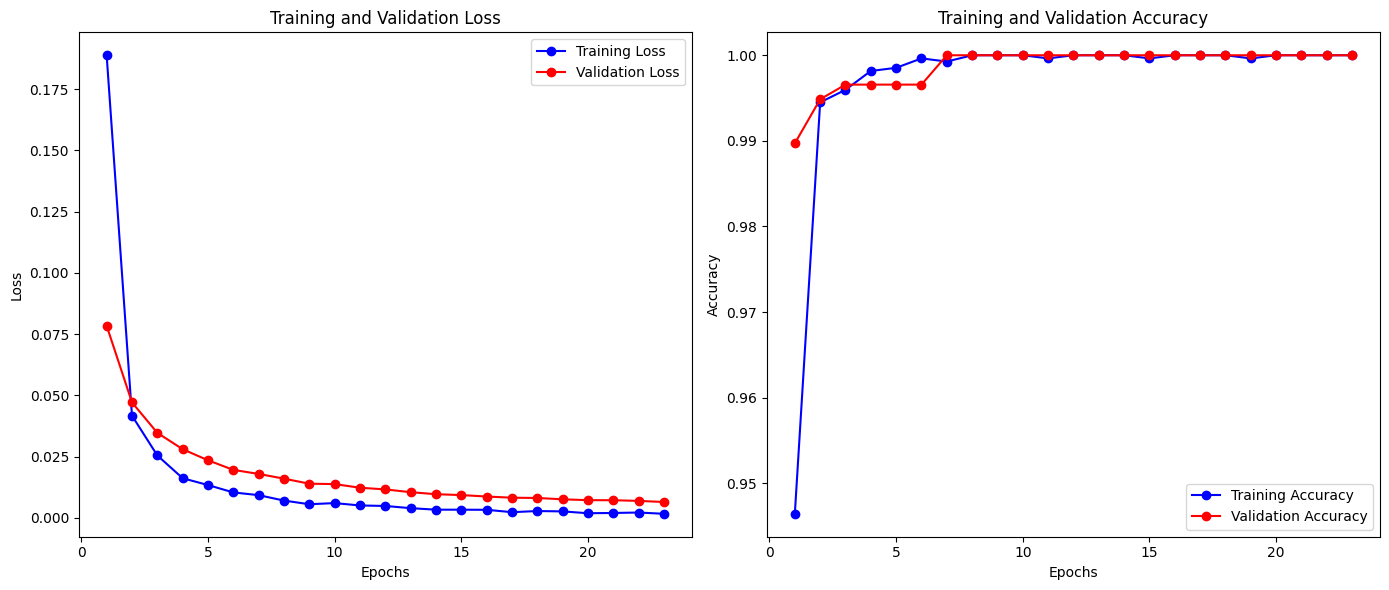


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      1.00      1.00       295
      studio       1.00      0.99      1.00       292

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587

--- Model Size ---
Model saved at: efficientnetb0_furniture_model.keras
File Size: 15.86 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to efficientnetb0_furniture_model.png


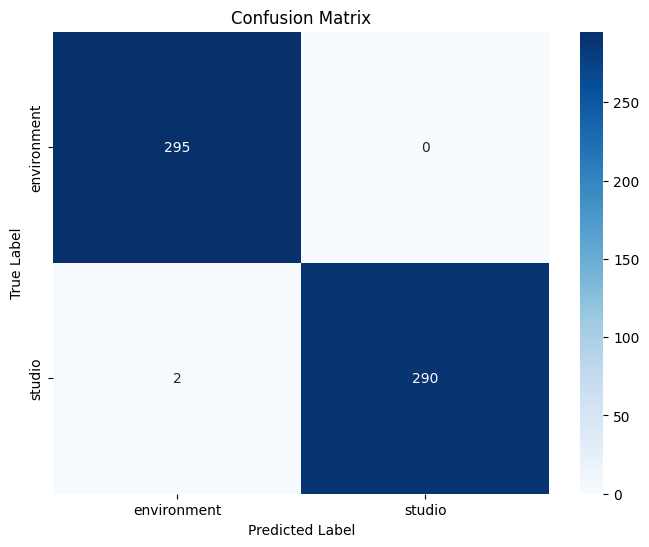

In [93]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [94]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for efficientnetb0_furniture_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 36.03 ms


### DenseNet121

In [95]:
MODEL_NAME = "densenet121_furniture_model.keras"
model = get_densenet121_model(img_shape=IMG_SIZE + (3,))
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                           

In [96]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 24s - loss: 0.2906 - binary_accuracy: 0.8818 - val_loss: 0.1135 - val_binary_accuracy: 0.9708 - lr: 0.0010 - 24s/epoch - 275ms/step
Epoch 2/100
86/86 - 16s - loss: 0.0743 - binary_accuracy: 0.9857 - val_loss: 0.0581 - val_binary_accuracy: 0.9949 - lr: 0.0010 - 16s/epoch - 186ms/step
Epoch 3/100
86/86 - 16s - loss: 0.0476 - binary_accuracy: 0.9901 - val_loss: 0.0436 - val_binary_accuracy: 0.9949 - lr: 0.0010 - 16s/epoch - 185ms/step
Epoch 4/100
86/86 - 16s - loss: 0.0319 - binary_accuracy: 0.9945 - val_loss: 0.0306 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 16s/epoch - 184ms/step
Epoch 5/100
86/86 - 16s - loss: 0.0254 - binary_accuracy: 0.9960 - val_loss: 0.0269 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 16s/epoch - 184ms/step
Epoch 6/100
86/86 - 16s - loss: 0.0216 - binary_accuracy: 0.9956 - val_loss: 0.0218 - val_binary_accuracy: 0.9983 - lr: 0.0010 - 16s/epoch - 186ms/step
Epoch 7/100
86/86 - 16s - loss: 0.0163 - binary_accuracy: 0.9978 - val_loss: 0.0193 - va

In [97]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 4s 209ms/step - loss: 0.0158 - binary_accuracy: 0.9966
Final Test Accuracy: 99.66%


In [98]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully saved to densenet121_furniture_model.keras



--- Generating Predictions for Reports ---
19/19 [==============================] - 5s 173ms/step

--- Generating Training Plots ---
Training plots saved to densenet121_furniture_model_history.png


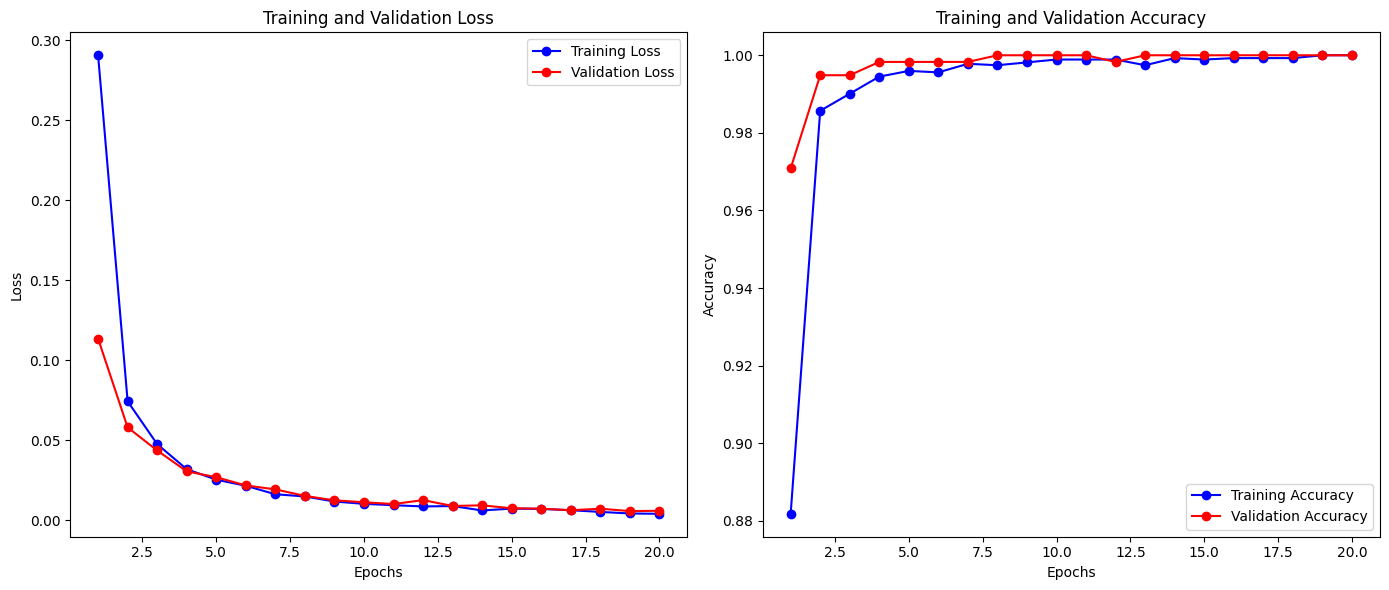


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      1.00      1.00       295
      studio       1.00      0.99      1.00       292

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587

--- Model Size ---
Model saved at: densenet121_furniture_model.keras
File Size: 27.58 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to densenet121_furniture_model.png


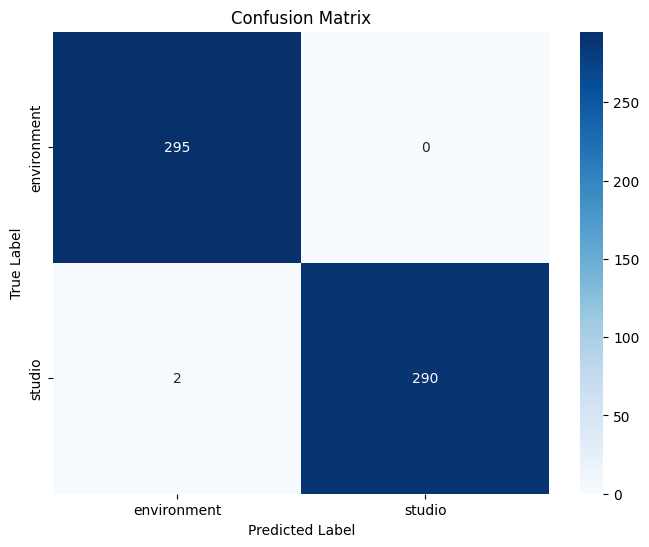

In [99]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [102]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 224, 224, 3)

--- Benchmarking LATENCY with a real image for densenet121_furniture_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 47.82 ms


### Xception

In [107]:
train_ds, val_ds, test_ds = load_datasets(
    TRAIN_DIR, VAL_DIR, TEST_DIR, img_size=(299,299), batch_size=BATCH_SIZE
)

Found 2725 files belonging to 2 classes.
Found 583 files belonging to 2 classes.
Found 587 files belonging to 2 classes.
Loading datasets with image size (299, 299)...
Found class names: ['environment', 'studio']


In [109]:
MODEL_NAME = "xception_furniture_model.keras"
model = get_xception_model(img_shape=(299,299) + (3,))
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 299, 299, 3)]     0         
                                                                 
 random_flip_10 (RandomFlip  (None, 299, 299, 3)       0         
 )                                                               
                                                                 
 random_rotation_10 (Random  (None, 299, 299, 3)       0         
 Rotation)                                                       
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                    

In [110]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose = 2
    
)

Epoch 1/100
86/86 - 45s - loss: 0.2641 - binary_accuracy: 0.9486 - val_loss: 0.1846 - val_binary_accuracy: 0.9743 - lr: 0.0010 - 45s/epoch - 522ms/step
Epoch 2/100
86/86 - 34s - loss: 0.0932 - binary_accuracy: 0.9839 - val_loss: 0.1193 - val_binary_accuracy: 0.9828 - lr: 0.0010 - 34s/epoch - 399ms/step
Epoch 3/100
86/86 - 34s - loss: 0.0621 - binary_accuracy: 0.9927 - val_loss: 0.0889 - val_binary_accuracy: 0.9880 - lr: 0.0010 - 34s/epoch - 398ms/step
Epoch 4/100
86/86 - 34s - loss: 0.0462 - binary_accuracy: 0.9941 - val_loss: 0.0725 - val_binary_accuracy: 0.9931 - lr: 0.0010 - 34s/epoch - 398ms/step
Epoch 5/100
86/86 - 34s - loss: 0.0394 - binary_accuracy: 0.9941 - val_loss: 0.0598 - val_binary_accuracy: 0.9897 - lr: 0.0010 - 34s/epoch - 399ms/step
Epoch 6/100
86/86 - 34s - loss: 0.0295 - binary_accuracy: 0.9963 - val_loss: 0.0521 - val_binary_accuracy: 0.9914 - lr: 0.0010 - 34s/epoch - 398ms/step
Epoch 7/100
86/86 - 34s - loss: 0.0242 - binary_accuracy: 0.9978 - val_loss: 0.0450 - va

In [111]:
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")


--- Final Evaluation on Test Set ---
19/19 [==============================] - 7s 334ms/step - loss: 0.0225 - binary_accuracy: 0.9932
Final Test Accuracy: 99.32%


In [112]:
model.save(MODEL_NAME)
print(f"Model successfully saved to {MODEL_NAME}")

Model successfully saved to xception_furniture_model.keras


/opt/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



--- Generating Predictions for Reports ---
19/19 [==============================] - 7s 318ms/step

--- Generating Training Plots ---
Training plots saved to xception_furniture_model_history.png


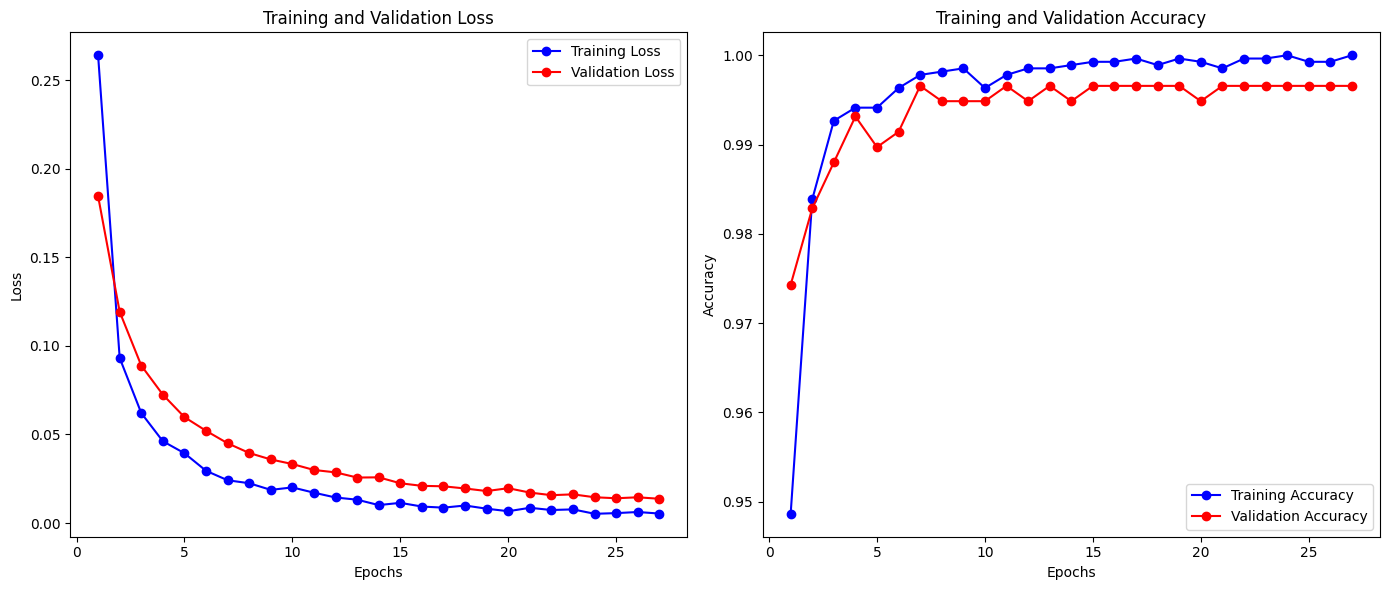


--- Classification Report ---
              precision    recall  f1-score   support

 environment       0.99      0.99      0.99       295
      studio       0.99      0.99      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

--- Model Size ---
Model saved at: xception_furniture_model.keras
File Size: 79.89 MB

--- Generating Confusion Matrix Plot ---
Confusion matrix saved to xception_furniture_model.png


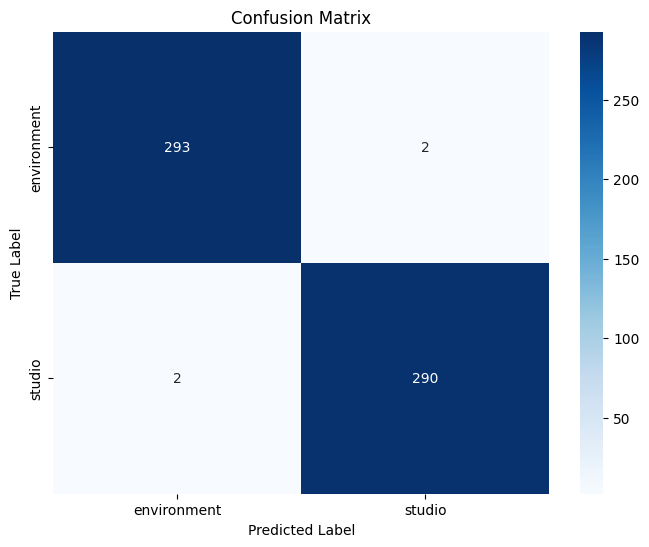

In [113]:
# --- 6. Generate All Reports and Plots ---

# Get Predictions and True Labels (needed for reports)
print("\n--- Generating Predictions for Reports ---")
y_pred_probs = model.predict(test_ds)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 7. (NEW) Plot the training history using our function
plot_training_history(history, save_path=f"{MODEL_NAME.replace('.keras','')}_history.png")

# Get class names for reports
class_names = ['environment', 'studio']

# 8. (NEW) Generate the full classification report
print_classification_report(y_true, y_pred_classes, class_names, MODEL_NAME)

# 9. Plot the confusion matrix (same as before)
print("\n--- Generating Confusion Matrix Plot ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(f"{MODEL_NAME.replace('.keras','')}.png")
print(f"Confusion matrix saved to {MODEL_NAME.replace('.keras','')}.png")
plt.show()

In [114]:
# Average latency per lookup
inference_latency(test_ds, model, MODEL_NAME.replace('.keras',''))

Successfully extracted one image with shape: (1, 299, 299, 3)

--- Benchmarking LATENCY with a real image for xception_furniture_model---
Warming up model...
Warm-up complete.
Running 100 predictions for latency test...
Average Latency (on a real image): 44.86 ms
